In [1]:
# Advance Lane Finding

In [2]:
#1.-Camera Calibartion

In [3]:
from moviepy.editor import VideoFileClip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import os
%matplotlib inline

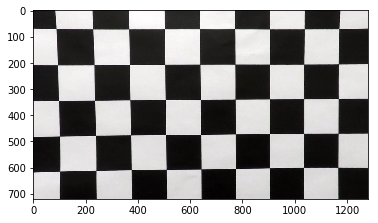

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
object_points = [] #real points 3D
image_points = [] #point of the different images 2D

obj_points = np.zeros((6*9,3), np.float32)
obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
total = 0
for image in images:
    
    #read each image
    img = mpimg.imread(image) 

    #convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #find corner for the cheesboard
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(obj_points)

#calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)

#test the calibration a plot image1
test_image = mpimg.imread('camera_cal/calibration1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)
plt.imshow(dst)



In [5]:
test_image = mpimg.imread('test_images/straight_lines1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)


In [6]:
#2.- COLOR TRANSFORM, GRADIENTS FOR BINARY IMAGE

In [7]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def get_binary_filtered_img(path,mtx, dist, saturation_thresh=(170, 255), sobel_thresh=(20, 100), light_thresh=(0,80)):
    
    #reading in an image
    if type(path) == type("String"):
        img = mpimg.imread(path)
    else:
        img = path
    
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    # Apply the following steps to img
    # Convert to hls color space
    hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    
    #calculating sobel for X
    sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    # Take the absolute value of the derivative or gradient
    abs_sobel_x = np.absolute(sobel_x)
    
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold color channel
    saturation_binary = np.zeros_like(s_channel)
    saturation_binary[(s_channel >= saturation_thresh[0]) & (s_channel <= saturation_thresh[1])] = 1
    
    light_binary = np.zeros_like(l_channel)
    light_binary[(l_channel >= light_thresh[0]) & (l_channel <= light_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, sobel_binary)) * 255
    combined_binary_1 = np.zeros_like(sobel_binary)
    combined_binary_1[(saturation_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[((saturation_binary == 1) | (sobel_binary == 1)) & (light_binary == 1)] = 1
    # 6) Return this mask as your binary_output image
    '''fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(2, 2, 1)
    plt.imshow(img)
    fig.add_subplot(2, 2, 2)
    plt.imshow(combined_binary_1, cmap= 'gray')
    fig.add_subplot(2, 2, 3)
    plt.imshow(combined_binary, cmap= 'gray')
    fig.add_subplot(2, 2, 4)
    plt.imshow((combined_binary - combined_binary_1), cmap= 'gray')'''
    
    
    return combined_binary, undist_image

binary_images = {}
undistorted_images = {}

list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    f_binary_image, undist_image  = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255))
    binary_images["binary_"+file] = f_binary_image
    undistorted_images ["undist_"+file] = undist_image
    

#plt.imshow(grad_binary, cmap='gray')

In [8]:
#3.-PERSPECTIVE TRANSFORM

In [9]:
def prespective_transform(img, source_point, destination_point):
    
    #transforming binary image to 3d image for drawing color lines
    img_with_lines_s = np.dstack(( img, img, img))* 255
    
    #parameters for color lines
    color=[255, 0, 0]
    thickness=4
    
    
    #Drawings color lines for source
    cv2.line(img_with_lines_s, (source_point[0,0], source_point[0,1]), (source_point[1,0], source_point[1,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[1,0], source_point[1,1]), (source_point[2,0], source_point[2,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[2,0], source_point[2,1]), (source_point[3,0], source_point[3,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[3,0], source_point[3,1]), (source_point[0,0], source_point[0,1]), color, thickness)
    
    
    img_size = (img.shape[1],img.shape[0])
    Warped_matrix = cv2.getPerspectiveTransform(source_point,destination_point)
    image_warpe = cv2.warpPerspective(img, Warped_matrix, img_size)
    
    #transforming binary image to 3d image for drawing color lines
    image_warpe_with_lines = np.dstack(( image_warpe, image_warpe, image_warpe))* 255
    
    #Drawings color lines for destination
    cv2.line(image_warpe_with_lines, (destination_point[0,0], destination_point[0,1]), (destination_point[1,0], destination_point[1,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[1,0], destination_point[1,1]), (destination_point[2,0], destination_point[2,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[2,0], destination_point[2,1]), (destination_point[3,0], destination_point[3,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[3,0], destination_point[3,1]), (destination_point[0,0], destination_point[0,1]), color, thickness)
    
    #print figures
    '''fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img_with_lines_s, cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(image_warpe_with_lines, cmap='gray')'''
    #plt.show()
    
    return image_warpe

#Source points
x1_s = 200
x2_s = 555
x3_s = 732
x4_s = 1100
y_top_s = 720
y_low_s = 480
#generating the array for source points
src = np.float32([[x1_s, y_top_s],[x2_s, y_low_s],[x3_s, y_low_s],[x4_s, y_top_s]])

#destination points
x_low_d = 290
x_top_d = 990
y_top_d = 720
y_low_d = 0
#generating the array for destination points
dst = np.float32([[x_low_d, y_top_d],[x_low_d, y_low_d],[x_top_d, y_low_d],[x_top_d, y_top_d]])

prespective_images = {}
fig = plt.figure(figsize=(100, 100))
for key, image in binary_images.items() :
    print (key)
    f_prespective_image = prespective_transform(image,src,dst)
    prespective_images["presp_"+key] = f_prespective_image
    

binary_straight_lines1.jpg
binary_straight_lines2.jpg
binary_test1.jpg
binary_test2.jpg
binary_test3.jpg
binary_test4.jpg
binary_test5.jpg
binary_test6.jpg


<Figure size 7200x7200 with 0 Axes>

In [10]:
#4.- SLIDING WINDOW DRAWING RECTANGLES

presp_binary_straight_lines1.jpg
presp_binary_straight_lines2.jpg
presp_binary_test1.jpg
presp_binary_test2.jpg
presp_binary_test3.jpg
presp_binary_test4.jpg
presp_binary_test5.jpg
presp_binary_test6.jpg


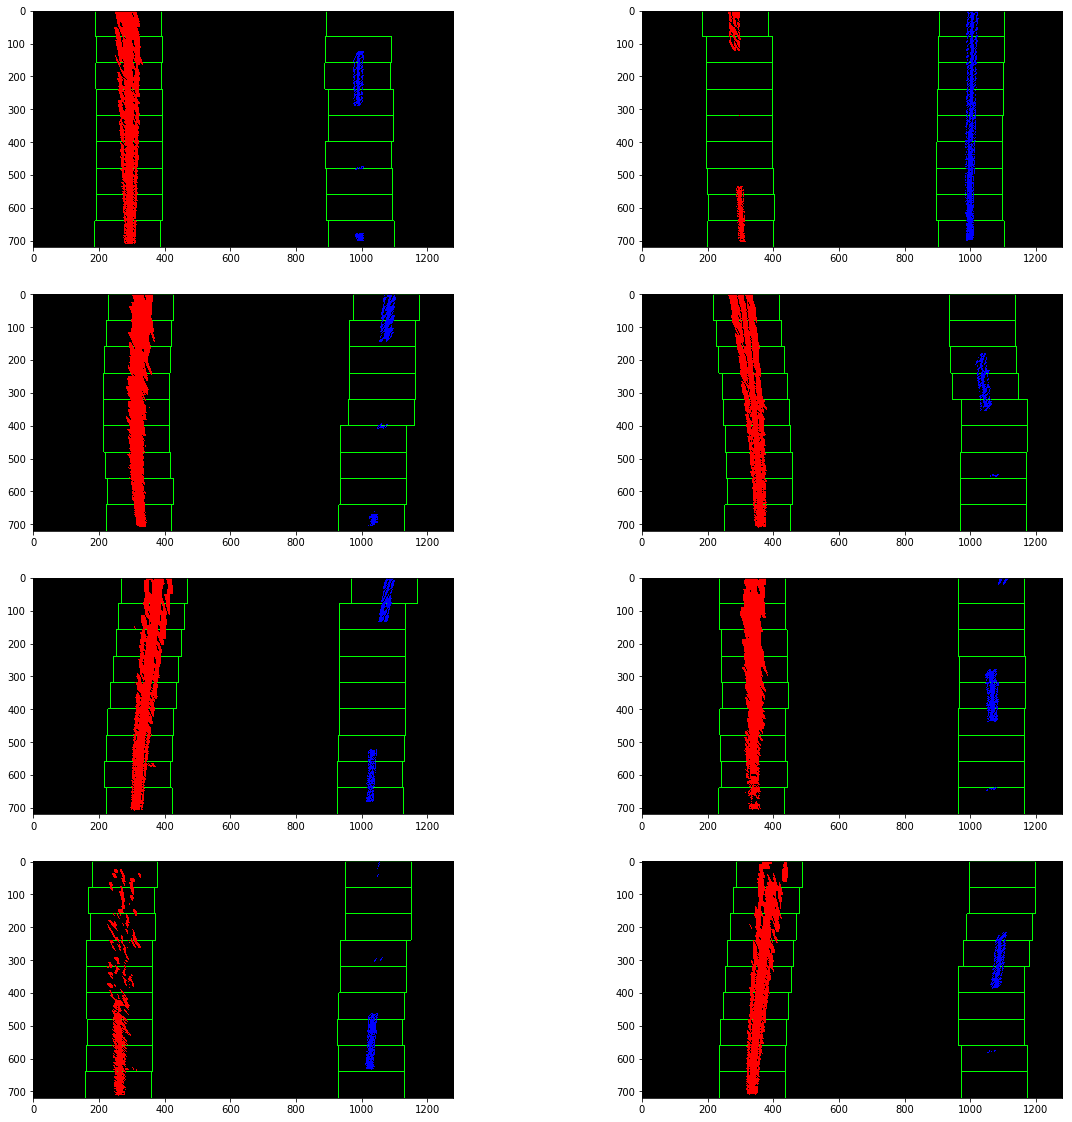

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &( nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    #Fit a second order polynomial to each using `np.polyfit` ###
    try:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
    except TypeError:
        left_fit = np.array([0,0,0])
        right_fit = np.array([0,0,0])
        pass


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return binary_warped, out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

poly_fit_images = {}
fig = plt.figure(figsize=(20, 20))
count = 1
for key, image in prespective_images.items() :
    print (key)
    fig.add_subplot(4, 2, count)
    poly_fit_images[key] = fit_polynomial(image)
    plt.imshow(poly_fit_images[key][1])
    count += 1

    

In [12]:
#5.- SEARCH FROM PREVIOUS POLYFIT RESULT AND CURVATURE CALCULATION

presp_binary_straight_lines1.jpg
presp_binary_straight_lines2.jpg
presp_binary_test1.jpg
presp_binary_test2.jpg
presp_binary_test3.jpg
presp_binary_test4.jpg
presp_binary_test5.jpg
presp_binary_test6.jpg


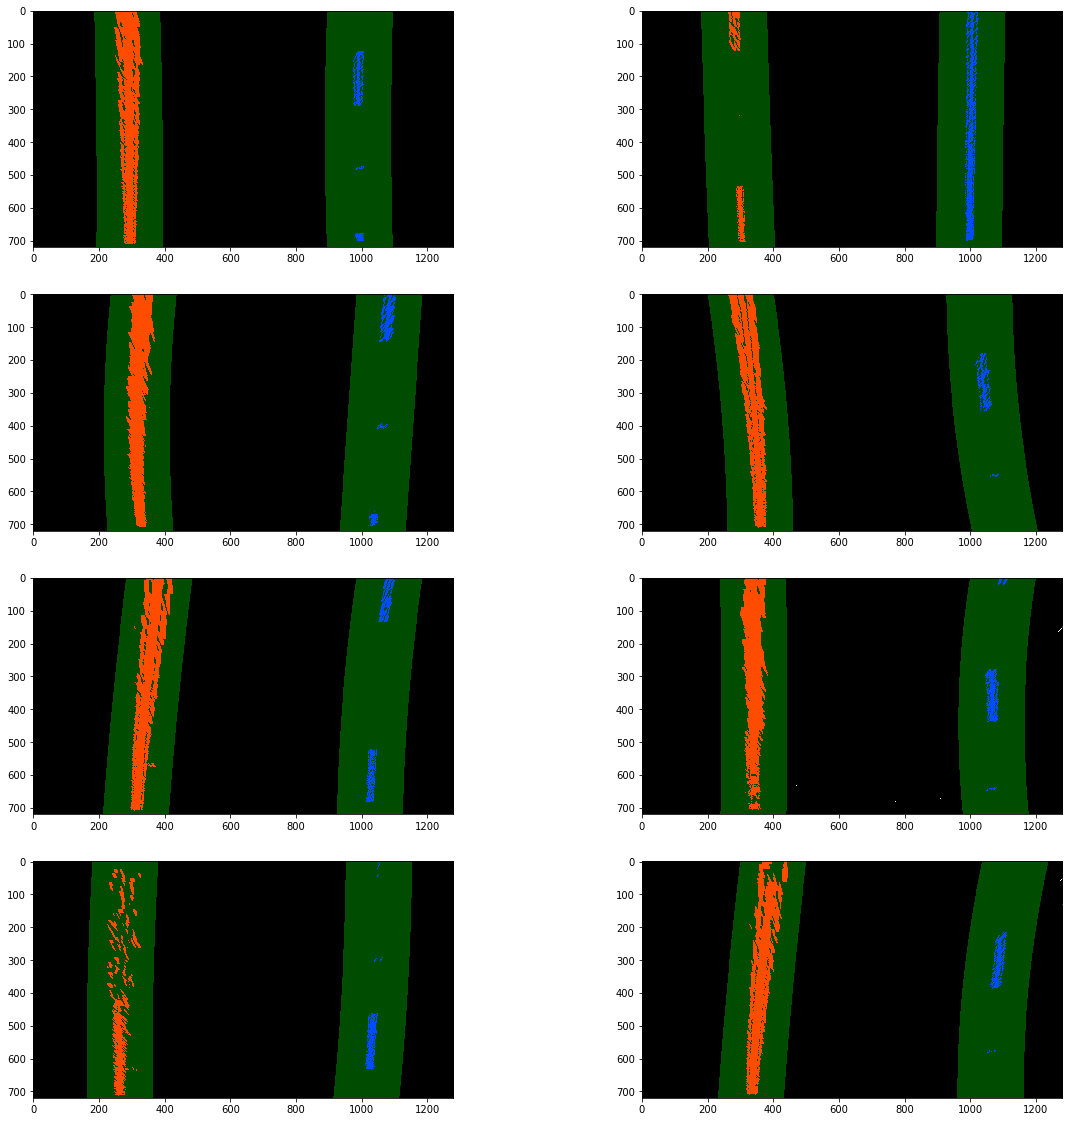

In [13]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    try:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
    except TypeError:
        left_fit = np.array([0,0,0])
        right_fit = np.array([0,0,0])
        pass
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Calculation the Curvature
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    try:
        left_fit_m = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
        right_fit_m = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
    except TypeError:
        left_fit_m = np.array([0,0,0])
        right_fit_m = np.array([0,0,0])
        pass
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image in m
    y_eval_m = y_eval * ym_per_pix
    
    ##### Implement the calculation of R_curve (radius of curvature) from f(y) = Ay^2 + By + C  f'(y) = 2Ay + B  f''(y) = 2A#####
    #Rcurve = ([1+ (dx/dy)^2]^(3/2))/(|(d2x/dy2)|) = ([1+ (2Ay + B)^2]^(3/2))/(|2A|)
    left_curve_rad = np.power((1+np.power(2*left_fit[0]*y_eval+left_fit[1],2)),(3/2))/np.absolute(2*left_fit[0]) 
    right_curve_rad = np.power((1+np.power(2*right_fit[0]*y_eval+right_fit[1],2)),(3/2))/np.absolute(2*right_fit[0])   
    #print(left_curve_rad, right_curve_rad)
    
    ### Real world calculation
    left_curve_rad_m = np.power((1+np.power(2*left_fit_m[0]*y_eval_m*+left_fit_m[1],2)),(3/2))/np.absolute(2*left_fit_m[0])  
    right_curve_rad_m = np.power((1+np.power(2*right_fit_m[0]*y_eval_m+right_fit_m[1],2)),(3/2))/np.absolute(2*right_fit_m[0])   
    #print(left_curve_rad_m, 'm', right_curve_rad_m, 'm')
    
    
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_curve_rad_m, right_curve_rad_m

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values ###

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit_new, right_fit_new, left_curve_rad_m, right_curve_rad_m = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty, left_fit_new, right_fit_new, left_curve_rad_m, right_curve_rad_m

#DU -Don't use it
search_around_poly_out = {}
fig = plt.figure(figsize=(20, 20))
count = 1
#poly_fit_images_items tuple contains binary_warped, out_img, left_fit, right_fit
for key, poly_fit_images_items in poly_fit_images.items() :
    print(key)
    fig.add_subplot(4, 2, count)
    search_around_poly_out[key] = search_around_poly(poly_fit_images_items[0],poly_fit_images_items[2],poly_fit_images_items[3])
    plt.imshow(search_around_poly_out[key][0])
    count += 1
    


In [14]:
#6.- DRAWING LINES REGION IN UNDISTORTED COLOR IMAGE

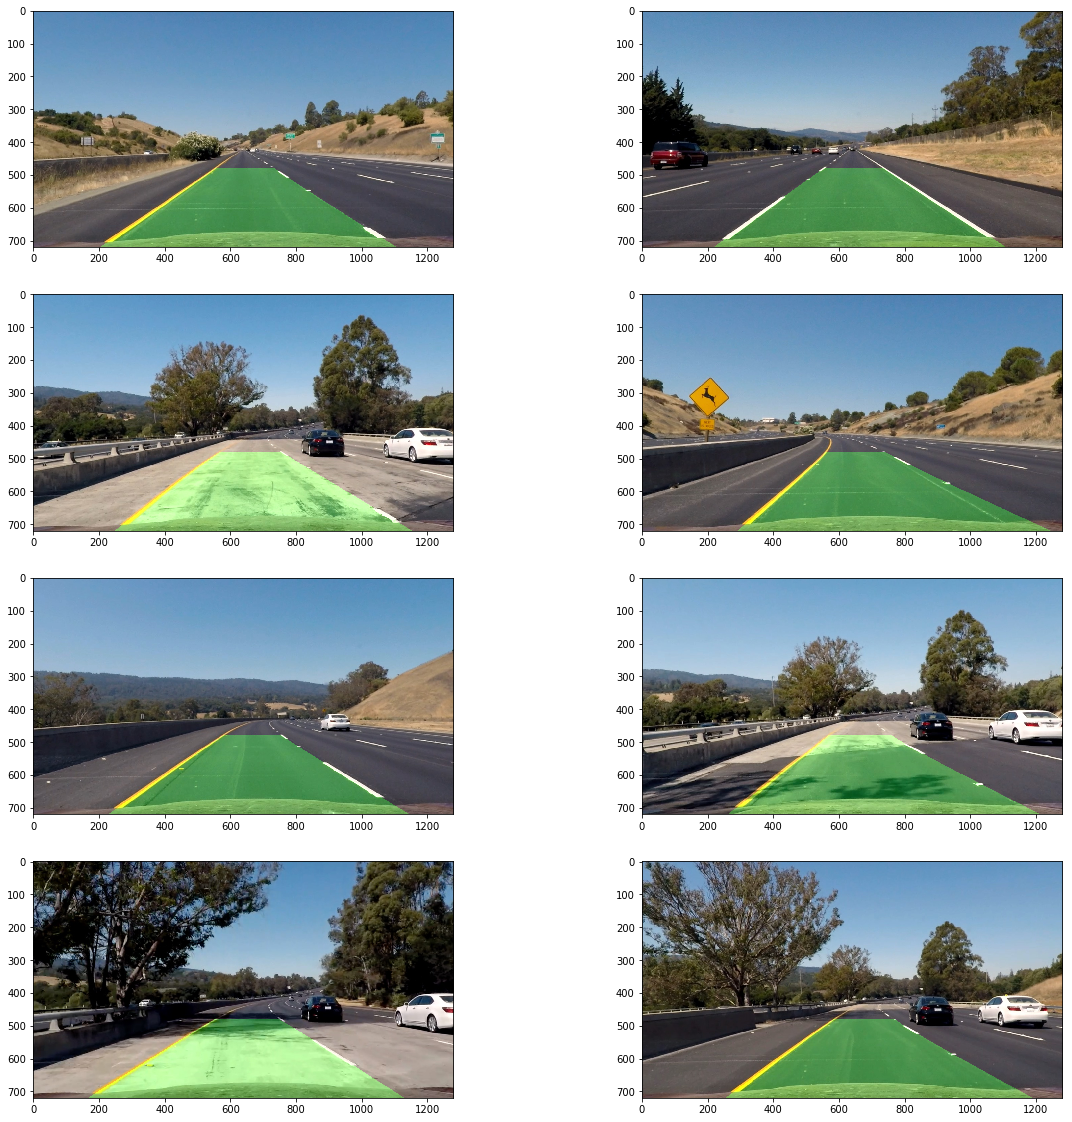

In [15]:
def draw_lines_region(undist_image, warped, left_fitx, right_fitx, ploty,source_points,destinaton_points):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #Calcultaing unwarped matrix 
    Inv_Warped_matrix = cv2.getPerspectiveTransform(source_points,destinaton_points)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Inv_Warped_matrix, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_region_lines = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return image_region_lines

fig = plt.figure(figsize=(20, 20))
count = 1
for file in list_images:
    fig.add_subplot(4, 2, count)
    image_full_region_lines = draw_lines_region(undistorted_images['undist_'+file], poly_fit_images['presp_binary_'+file][0], search_around_poly_out['presp_binary_'+file][1], search_around_poly_out['presp_binary_'+file][2], search_around_poly_out['presp_binary_'+file][3],dst,src)
    cool_image = image_full_region_lines
    plt.imshow(cool_image)
    count += 1

In [16]:
#7 CALIING ALL PREVIOUS FUNCTIONS#

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False   
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [np.array([False])] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for the last n fits
        self.n_fits = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        #counts the number of the first n loops 
        self.loops_counter = 0
        #counts the number of error of calculation
        self.error_fit = 0

#Calculate average of left and right coeficients
def average_coeficients(left_line_n_fits, right_line_n_fits):
    left_line.best_fit = [np.array([0,0,0])] 
    right_line.best_fit = [np.array([0,0,0])] 
    
    for i in range(left_line_n_fits.shape[0]): 
        left_line.best_fit += left_line_n_fits[i]
    left_line.best_fit = left_line.best_fit / left_line_n_fits.shape[0]
    
    for i in range(right_line_n_fits.shape[0]): 
        right_line.best_fit += right_line_n_fits[i]
    right_line.best_fit = right_line.best_fit / right_line_n_fits.shape[0]


#check if the lines are parallel base on the distance between the top, middle and low points on x axis of the 2 lines
        
def line_distance_comparison(left_fitx, right_fitx):
    
    #distance between lines in pixels 
    dist_btween_lines = 700
    
    #treshhold of parallel lines between x and y
    between_lines_threshhold = 50
    
    if ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1]) < (dist_btween_lines + between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)//2]-left_fitx[len(left_fitx)//2]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)//2]-left_fitx[len(left_fitx)//2]) < (dist_btween_lines + between_lines_threshhold)) &\
    ((right_fitx[0]-left_fitx[0]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[0]-left_fitx[0]) < (dist_btween_lines + between_lines_threshhold)):
        return True
    else:
        return False
        
def main_call(path_image):

    #define de number of n loops
    n_loops = 5
    
    #treshhold of parallel lines between same line x or
    between_same_lines_threshhold = 15
    
    #thershhold for continues bad calculation of a line fit
    bad_calc_line_threshhold = 5
    
    #Undistort the image and get binary image
    final_binary_image, undist_image  = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255))
    #generat 3d binary image just for testing
    final_binary_image_3d_format = np.dstack((final_binary_image, final_binary_image, final_binary_image))*255
    
    #Use perspective trasform for eagle view
    final_prespective_image = prespective_transform(final_binary_image,src,dst)
    
    
    if (left_line.detected == False  & right_line.detected == False) :
        #return polyfit for left and right line
        binary_warped, out_img, left_line.current_fit, right_line.current_fit, left_fitx, right_fitx, ploty = fit_polynomial(final_prespective_image)
        left_line.detected = right_line.detected = True
        print_test_image = out_img

    else:
        #draw line band base on polyfit
        result_image_band_line, left_fitx, right_fitx, ploty, left_line.current_fit, right_line.current_fit, \
        left_curve_rad_m, right_curve_rad_m = search_around_poly(final_prespective_image, left_line.current_fit, \
        right_line.current_fit)
        left_line.radius_of_curvature = left_curve_rad_m
        right_line.radius_of_curvature = right_curve_rad_m
        print_test_image = result_image_band_line
    

    
    #Compare the distance in three point bottom, middle and top in Y axis and decide if the they meet the treshholds
    if  left_line.loops_counter == 0 & right_line.loops_counter == 0 :
        left_line.n_fits = np.array([left_line.current_fit])
        right_line.n_fits = np.array([right_line.current_fit])
        left_line.loops_counter += 1
        right_line.loops_counter += 1
        
        
    elif ((left_line.loops_counter < n_loops) & (right_line.loops_counter < n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            left_line.loops_counter += 1
            right_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.loops_counter += 1
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.loops_counter += 1
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
        
 

    elif ((left_line.loops_counter == n_loops) & (right_line.loops_counter < n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            right_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.loops_counter += 1
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            
    elif ((left_line.loops_counter < n_loops) & (right_line.loops_counter == n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            left_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.loops_counter += 1
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)


    else:
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
    #calculate the average of the coeficients
    average_coeficients(left_line.n_fits, right_line.n_fits)
            
    if (left_line.error_fit >= bad_calc_line_threshhold) | (right_line.error_fit >= bad_calc_line_threshhold) :
        left_line.detected = right_line.detected = False
        print("Recalculating square fitting")
            
    #Check which line or line is not calculated correctly and choose the correct coeficient (Ax^2 + Bx + C) used in this loop to plot the image
    
    #If the coeficients are good store them and calculate the average, if not increment count of faluty and use stored average, if the counter is equal to 3 call fit_polynomial function to calculate squares
    
    #Calculate the offset to the center line
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_between_lines = ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1])/2)+left_fitx[len(left_fitx)-1]
    Offset_center_lines = final_binary_image.shape[1]/2 - center_between_lines
    left_line.line_base_pos = right_line.line_base_pos = Offset_center_lines*xm_per_pix

    #draw region in green for undistorted image
    f_image_region_lines = draw_lines_region(undist_image, final_prespective_image, left_fitx, right_fitx, ploty,dst,src)
    
    
    #writing the lines curvature from each line as text in the image
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    leftLineTextPosition = (10,20)
    rightLineTextPosition = (10,50)
    offcetToCenterPosition = (10,80)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(f_image_region_lines,'Curvature left line: '+str(np.round(left_line.radius_of_curvature,2))+ ' m', 
    leftLineTextPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(f_image_region_lines,'Curvature right line: '+str(np.round(right_line.radius_of_curvature,2))+ ' m', 
    rightLineTextPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(f_image_region_lines,'Offset to center: '+str(np.round(left_line.line_base_pos,2))+ ' m', 
    offcetToCenterPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    return f_image_region_lines #image_region_lines

left_line = Line()
right_line = Line()

'''
fig = plt.figure(figsize=(20, 20))
count = 1
list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    main_call(path_image)
    print_image = main_call(path_image)
    fig.add_subplot(4, 2, count)
    plt.imshow(print_image)
    count += 1'''
    

input_video = "project_video.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,1)
clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(main_call)
white_clip.write_videofile("output_images/"+input_video)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing audio in project_videoTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:01<00:00, 667.47it/s]


[MoviePy] Done.
[MoviePy] Writing video output_images/project_video.mp4


 41%|████      | 512/1261 [01:10<01:35,  7.84it/s]

Recalculating square fitting


 44%|████▍     | 552/1261 [01:16<01:35,  7.40it/s]

Recalculating square fitting


 44%|████▍     | 553/1261 [01:17<02:18,  5.12it/s]

Recalculating square fitting


 44%|████▍     | 554/1261 [01:17<02:03,  5.71it/s]

Recalculating square fitting


 44%|████▍     | 555/1261 [01:17<01:52,  6.28it/s]

Recalculating square fitting


 44%|████▍     | 556/1261 [01:17<01:43,  6.84it/s]

Recalculating square fitting


 44%|████▍     | 557/1261 [01:17<02:53,  4.06it/s]

Recalculating square fitting


 44%|████▍     | 558/1261 [01:18<02:30,  4.68it/s]

Recalculating square fitting


 44%|████▍     | 559/1261 [01:18<02:15,  5.18it/s]

Recalculating square fitting


 44%|████▍     | 560/1261 [01:18<02:04,  5.64it/s]

Recalculating square fitting


 44%|████▍     | 561/1261 [01:18<02:26,  4.78it/s]

Recalculating square fitting


 45%|████▍     | 562/1261 [01:18<02:30,  4.63it/s]

Recalculating square fitting


 45%|████▍     | 563/1261 [01:19<02:09,  5.39it/s]

Recalculating square fitting


 45%|████▍     | 564/1261 [01:19<01:52,  6.17it/s]

Recalculating square fitting


 45%|████▍     | 565/1261 [01:19<01:41,  6.85it/s]

Recalculating square fitting


 45%|████▌     | 572/1261 [01:20<01:28,  7.83it/s]

Recalculating square fitting


 45%|████▌     | 573/1261 [01:20<01:25,  8.09it/s]

Recalculating square fitting


 46%|████▌     | 574/1261 [01:20<02:14,  5.10it/s]

Recalculating square fitting


 46%|████▌     | 575/1261 [01:20<01:57,  5.85it/s]

Recalculating square fitting


 46%|████▌     | 576/1261 [01:20<01:46,  6.43it/s]

Recalculating square fitting


 46%|████▌     | 577/1261 [01:21<01:42,  6.68it/s]

Recalculating square fitting


 46%|████▌     | 578/1261 [01:21<01:55,  5.92it/s]

Recalculating square fitting


 46%|████▌     | 579/1261 [01:21<01:44,  6.55it/s]

Recalculating square fitting


 46%|████▌     | 580/1261 [01:21<01:52,  6.05it/s]

Recalculating square fitting


 47%|████▋     | 592/1261 [01:22<01:15,  8.86it/s]

Recalculating square fitting


 47%|████▋     | 593/1261 [01:23<01:15,  8.89it/s]

Recalculating square fitting


 47%|████▋     | 594/1261 [01:23<01:14,  8.92it/s]

Recalculating square fitting


 47%|████▋     | 595/1261 [01:23<01:14,  8.89it/s]

Recalculating square fitting


 47%|████▋     | 596/1261 [01:23<01:14,  8.97it/s]

Recalculating square fitting


 47%|████▋     | 597/1261 [01:23<01:13,  9.01it/s]

Recalculating square fitting


 47%|████▋     | 598/1261 [01:23<01:13,  9.05it/s]

Recalculating square fitting


 48%|████▊     | 599/1261 [01:23<01:12,  9.12it/s]

Recalculating square fitting


 48%|████▊     | 600/1261 [01:23<01:13,  9.03it/s]

Recalculating square fitting


 48%|████▊     | 601/1261 [01:23<01:14,  8.92it/s]

Recalculating square fitting


 48%|████▊     | 602/1261 [01:24<01:13,  8.95it/s]

Recalculating square fitting


 48%|████▊     | 603/1261 [01:24<01:13,  8.96it/s]

Recalculating square fitting


 48%|████▊     | 604/1261 [01:24<01:14,  8.86it/s]

Recalculating square fitting


 48%|████▊     | 605/1261 [01:24<01:13,  8.98it/s]

Recalculating square fitting


 48%|████▊     | 606/1261 [01:24<01:12,  9.02it/s]

Recalculating square fitting


 48%|████▊     | 607/1261 [01:24<01:11,  9.17it/s]

Recalculating square fitting


 48%|████▊     | 608/1261 [01:24<01:12,  9.02it/s]

Recalculating square fitting


 48%|████▊     | 609/1261 [01:24<01:12,  9.01it/s]

Recalculating square fitting


 48%|████▊     | 610/1261 [01:24<01:13,  8.92it/s]

Recalculating square fitting


 48%|████▊     | 611/1261 [01:25<01:13,  8.89it/s]

Recalculating square fitting


 49%|████▊     | 612/1261 [01:25<01:12,  8.89it/s]

Recalculating square fitting


 49%|████▊     | 613/1261 [01:25<01:12,  8.99it/s]

Recalculating square fitting


 61%|██████    | 769/1261 [01:48<00:59,  8.32it/s]

Recalculating square fitting


 67%|██████▋   | 845/1261 [01:57<00:48,  8.54it/s]

Recalculating square fitting


 67%|██████▋   | 846/1261 [01:58<00:48,  8.47it/s]

Recalculating square fitting


 67%|██████▋   | 847/1261 [01:58<00:47,  8.70it/s]

Recalculating square fitting


 67%|██████▋   | 848/1261 [01:58<00:46,  8.79it/s]

Recalculating square fitting


 67%|██████▋   | 849/1261 [01:58<00:46,  8.90it/s]

Recalculating square fitting


 67%|██████▋   | 850/1261 [01:58<00:45,  9.01it/s]

Recalculating square fitting


 69%|██████▉   | 867/1261 [02:00<00:45,  8.57it/s]

Recalculating square fitting


 69%|██████▉   | 868/1261 [02:00<00:46,  8.43it/s]

Recalculating square fitting


 69%|██████▉   | 869/1261 [02:00<00:45,  8.62it/s]

Recalculating square fitting


 69%|██████▉   | 870/1261 [02:00<00:44,  8.72it/s]

Recalculating square fitting


 69%|██████▉   | 871/1261 [02:00<00:44,  8.79it/s]

Recalculating square fitting


 69%|██████▉   | 872/1261 [02:01<00:43,  8.95it/s]

Recalculating square fitting


 69%|██████▉   | 873/1261 [02:01<00:43,  9.00it/s]

Recalculating square fitting


 69%|██████▉   | 874/1261 [02:01<00:42,  9.07it/s]

Recalculating square fitting


 69%|██████▉   | 875/1261 [02:01<00:42,  9.13it/s]

Recalculating square fitting


 69%|██████▉   | 876/1261 [02:01<00:41,  9.17it/s]

Recalculating square fitting


 70%|██████▉   | 877/1261 [02:01<00:42,  9.09it/s]

Recalculating square fitting


 70%|██████▉   | 878/1261 [02:01<00:42,  9.11it/s]

Recalculating square fitting


 70%|██████▉   | 879/1261 [02:01<00:42,  9.08it/s]

Recalculating square fitting


 70%|██████▉   | 880/1261 [02:01<00:42,  9.04it/s]

Recalculating square fitting


 70%|██████▉   | 881/1261 [02:01<00:41,  9.05it/s]

Recalculating square fitting


 70%|██████▉   | 882/1261 [02:02<00:41,  9.07it/s]

Recalculating square fitting


 70%|███████   | 883/1261 [02:02<00:41,  9.13it/s]

Recalculating square fitting


 70%|███████   | 884/1261 [02:02<00:40,  9.20it/s]

Recalculating square fitting


 70%|███████   | 885/1261 [02:02<00:40,  9.18it/s]

Recalculating square fitting


 71%|███████   | 895/1261 [02:03<00:42,  8.58it/s]

Recalculating square fitting


 71%|███████   | 896/1261 [02:03<00:42,  8.62it/s]

Recalculating square fitting


 71%|███████   | 897/1261 [02:03<00:41,  8.84it/s]

Recalculating square fitting


 71%|███████   | 898/1261 [02:03<00:40,  8.97it/s]

Recalculating square fitting


 72%|███████▏  | 907/1261 [02:05<00:43,  8.15it/s]

Recalculating square fitting


 72%|███████▏  | 908/1261 [02:05<00:43,  8.12it/s]

Recalculating square fitting


 72%|███████▏  | 909/1261 [02:05<00:42,  8.27it/s]

Recalculating square fitting


 72%|███████▏  | 910/1261 [02:05<00:42,  8.35it/s]

Recalculating square fitting


 73%|███████▎  | 918/1261 [02:06<00:42,  8.11it/s]

Recalculating square fitting


 73%|███████▎  | 919/1261 [02:06<00:42,  8.13it/s]

Recalculating square fitting


 73%|███████▎  | 920/1261 [02:06<00:41,  8.30it/s]

Recalculating square fitting


 73%|███████▎  | 921/1261 [02:06<00:39,  8.57it/s]

Recalculating square fitting


 73%|███████▎  | 922/1261 [02:06<00:39,  8.62it/s]

Recalculating square fitting


 73%|███████▎  | 923/1261 [02:06<00:38,  8.81it/s]

Recalculating square fitting


 76%|███████▌  | 955/1261 [02:10<00:36,  8.44it/s]

Recalculating square fitting


 76%|███████▌  | 956/1261 [02:10<00:36,  8.45it/s]

Recalculating square fitting


 76%|███████▌  | 957/1261 [02:10<00:35,  8.59it/s]

Recalculating square fitting


 76%|███████▌  | 958/1261 [02:11<00:35,  8.64it/s]

Recalculating square fitting


 79%|███████▉  | 995/1261 [02:15<00:31,  8.51it/s]

Recalculating square fitting


 79%|███████▉  | 996/1261 [02:15<00:31,  8.43it/s]

Recalculating square fitting


 79%|███████▉  | 1002/1261 [02:16<00:30,  8.60it/s]

Recalculating square fitting


 80%|███████▉  | 1003/1261 [02:16<00:30,  8.58it/s]

Recalculating square fitting


 80%|███████▉  | 1004/1261 [02:16<00:29,  8.64it/s]

Recalculating square fitting


 80%|███████▉  | 1005/1261 [02:16<00:29,  8.74it/s]

Recalculating square fitting


 80%|███████▉  | 1006/1261 [02:16<00:28,  8.87it/s]

Recalculating square fitting


 80%|████████  | 1012/1261 [02:17<00:28,  8.69it/s]

Recalculating square fitting


 80%|████████  | 1013/1261 [02:17<00:28,  8.67it/s]

Recalculating square fitting


 80%|████████  | 1014/1261 [02:17<00:28,  8.76it/s]

Recalculating square fitting


 80%|████████  | 1015/1261 [02:17<00:27,  8.81it/s]

Recalculating square fitting


 81%|████████  | 1016/1261 [02:17<00:27,  8.87it/s]

Recalculating square fitting


 81%|████████  | 1017/1261 [02:17<00:27,  8.97it/s]

Recalculating square fitting


 81%|████████  | 1018/1261 [02:17<00:27,  9.00it/s]

Recalculating square fitting


 81%|████████  | 1019/1261 [02:18<00:26,  9.04it/s]

Recalculating square fitting


 81%|████████  | 1020/1261 [02:18<00:26,  9.09it/s]

Recalculating square fitting


 81%|████████  | 1021/1261 [02:18<00:26,  9.11it/s]

Recalculating square fitting


 81%|████████  | 1022/1261 [02:18<00:26,  9.08it/s]

Recalculating square fitting


 81%|████████  | 1023/1261 [02:18<00:26,  9.08it/s]

Recalculating square fitting


 81%|████████  | 1024/1261 [02:18<00:26,  9.06it/s]

Recalculating square fitting


 81%|████████▏ | 1025/1261 [02:18<00:25,  9.10it/s]

Recalculating square fitting


 81%|████████▏ | 1026/1261 [02:18<00:26,  9.00it/s]

Recalculating square fitting


 81%|████████▏ | 1027/1261 [02:18<00:26,  8.90it/s]

Recalculating square fitting


 82%|████████▏ | 1028/1261 [02:19<00:25,  8.96it/s]

Recalculating square fitting


 82%|████████▏ | 1029/1261 [02:19<00:25,  9.02it/s]

Recalculating square fitting


 82%|████████▏ | 1030/1261 [02:19<00:25,  9.06it/s]

Recalculating square fitting


 82%|████████▏ | 1031/1261 [02:19<00:25,  9.06it/s]

Recalculating square fitting


 82%|████████▏ | 1032/1261 [02:19<00:25,  9.05it/s]

Recalculating square fitting


 82%|████████▏ | 1033/1261 [02:19<00:25,  9.04it/s]

Recalculating square fitting


 82%|████████▏ | 1034/1261 [02:19<00:25,  9.08it/s]

Recalculating square fitting


 83%|████████▎ | 1041/1261 [02:20<00:24,  8.96it/s]

Recalculating square fitting


 83%|████████▎ | 1048/1261 [02:21<00:23,  8.98it/s]

Recalculating square fitting


 83%|████████▎ | 1049/1261 [02:21<00:23,  8.94it/s]

Recalculating square fitting


 83%|████████▎ | 1050/1261 [02:21<00:23,  9.07it/s]

Recalculating square fitting


 83%|████████▎ | 1051/1261 [02:21<00:23,  9.13it/s]

Recalculating square fitting


 83%|████████▎ | 1052/1261 [02:21<00:22,  9.20it/s]

Recalculating square fitting


 84%|████████▎ | 1053/1261 [02:21<00:22,  9.21it/s]

Recalculating square fitting


 85%|████████▌ | 1076/1261 [02:24<00:24,  7.70it/s]

Recalculating square fitting


 86%|████████▌ | 1087/1261 [02:26<00:20,  8.44it/s]

Recalculating square fitting


 86%|████████▋ | 1088/1261 [02:26<00:20,  8.44it/s]

Recalculating square fitting


 89%|████████▉ | 1123/1261 [02:30<00:15,  8.64it/s]

Recalculating square fitting


 89%|████████▉ | 1124/1261 [02:30<00:16,  8.49it/s]

Recalculating square fitting


 89%|████████▉ | 1125/1261 [02:30<00:15,  8.67it/s]

Recalculating square fitting


 89%|████████▉ | 1126/1261 [02:30<00:15,  8.76it/s]

Recalculating square fitting


 89%|████████▉ | 1127/1261 [02:30<00:15,  8.85it/s]

Recalculating square fitting


 89%|████████▉ | 1128/1261 [02:30<00:15,  8.81it/s]

Recalculating square fitting


 90%|████████▉ | 1129/1261 [02:30<00:14,  8.92it/s]

Recalculating square fitting


 90%|████████▉ | 1130/1261 [02:31<00:14,  8.98it/s]

Recalculating square fitting


 90%|████████▉ | 1131/1261 [02:31<00:14,  8.99it/s]

Recalculating square fitting


 90%|████████▉ | 1132/1261 [02:31<00:14,  8.90it/s]

Recalculating square fitting


 90%|████████▉ | 1133/1261 [02:31<00:14,  8.95it/s]

Recalculating square fitting


 92%|█████████▏| 1157/1261 [02:34<00:12,  8.63it/s]

Recalculating square fitting


 92%|█████████▏| 1158/1261 [02:34<00:11,  8.63it/s]

Recalculating square fitting


 92%|█████████▏| 1159/1261 [02:34<00:11,  8.78it/s]

Recalculating square fitting


 94%|█████████▍| 1189/1261 [02:38<00:09,  7.58it/s]

Recalculating square fitting


 98%|█████████▊| 1234/1261 [02:43<00:03,  8.54it/s]

Recalculating square fitting


 98%|█████████▊| 1235/1261 [02:43<00:03,  8.57it/s]

Recalculating square fitting


 98%|█████████▊| 1236/1261 [02:43<00:02,  8.73it/s]

Recalculating square fitting


 98%|█████████▊| 1237/1261 [02:43<00:02,  8.77it/s]

Recalculating square fitting


100%|█████████▉| 1260/1261 [02:46<00:00,  8.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

